# Pattern Similarity Search (PSS)

A michanish to impute time series which perform better than Linear Interpolation, Mean-based Interpolation, ARIMA, LSTM
The PSS gives outstanding results when the time series is longer and the inputation gap is long-term. The models like ARIMA and LSTM does not perform well for long-term gaps. Also, PSS can perseve the shape of the missing values.

In [211]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [376]:
#Import the time series
df_timeseries = pd.read_csv(f"data_resampled/103/S103_resampled.csv")
df_timeseries = df_timeseries[["time","sensor_n"]]
df_timeseries

,time,sensor_n
0,2021-09-07 16:00:00.000,0.004534
1,2021-09-07 16:00:00.010,0.003255
2,2021-09-07 16:00:00.020,0.004782
3,2021-09-07 16:00:00.030,-0.005402
4,2021-09-07 16:00:00.040,0.002628
...,...,...
147843,2021-09-07 16:24:38.430,0.001698
147844,2021-09-07 16:24:38.440,0.000867
147845,2021-09-07 16:24:38.450,-0.000429
147846,2021-09-07 16:24:38.460,0.003519


### Simulate a gap in the data

We simulate a gap in the data and this is also the ground truth.
In this example we simulate a gap of 50 data points.

In [377]:
gap_start = 100000
gap_end = 100050

ground_truth = df_timeseries.iloc[gap_start:gap_end,1].values.copy()
ground_truth

array([ 2.68589243e-02,  2.16382410e-02,  1.32591844e-02,  9.98153791e-03,
        4.36608445e-03,  1.26898785e-02,  2.37589972e-03,  9.89168420e-05,
        2.11855227e-03, -7.77671367e-03, -2.96401991e-03, -3.42290806e-03,
       -9.76699083e-03, -1.07953841e-02, -1.27907193e-02, -2.08271483e-03,
       -1.75489699e-02, -5.96499264e-03, -9.28078284e-03, -1.42521535e-02,
       -1.11403224e-02, -9.84970932e-03, -4.25839461e-03, -7.59218429e-03,
       -1.01410845e-02, -9.23607790e-03, -1.13316453e-02, -1.04492268e-02,
       -4.86023509e-03, -1.00540003e-02, -1.11618112e-02, -2.35835679e-03,
       -1.42482718e-04, -3.02940993e-03, -6.21263086e-03, -1.23559228e-03,
       -1.07409702e-05,  1.22850076e-03, -8.08103972e-03, -8.85741060e-03,
       -8.60887622e-03, -7.92932901e-03, -3.75697117e-03, -1.87358566e-03,
       -2.48633827e-03,  2.38474861e-03, -6.42768086e-04,  2.66664154e-03,
        6.81976981e-04, -3.45398659e-03])

In [378]:
df_timeseries.iloc[gap_start:gap_end,1]=0
df_timeseries.iloc[gap_start-5:gap_end+5]

,time,sensor_n
99995,2021-09-07 16:16:39.950,0.048939
99996,2021-09-07 16:16:39.960,0.040822
99997,2021-09-07 16:16:39.970,0.034872
99998,2021-09-07 16:16:39.980,0.026488
99999,2021-09-07 16:16:39.990,0.033994
100000,2021-09-07 16:16:40.000,0.000000
100001,2021-09-07 16:16:40.010,0.000000
100002,2021-09-07 16:16:40.020,0.000000
100003,2021-09-07 16:16:40.030,0.000000
100004,2021-09-07 16:16:40.040,0.000000


### Select the best window for PSS

Based on my study, I found that there is a best window size for each gap lenth.
 <table align="left">
        <tr><th>Gap size</th><th>Best window</th></tr>
        <tr><td>14</td><td>80</td></tr>
        <tr><td>25</td><td>170</td></tr>
        <tr><td>50</td><td>270</td></tr>
        <tr><td>100</td><td>800</td></tr>
        <tr><td>200</td><td>1400</td></tr>
        <tr><td>300</td><td>2450</td></tr>
   </table>

We add two new columns to time series call "detect" and "detect_buff".

The "detect" indicates the missing values in the time series.

As the source window for PSS, we capture the data points before and after the missing value area. This area is determine by the search window size. We pick a search window bigger than the missing values and place in centered in the missing values area. Then we capture the source window data points.

In [379]:
df_timeseries["detect"]=0
df_timeseries.iloc[gap_start:gap_end,2]=1 #If we have multiple missing gaps in the time series, you can increment this number

df_timeseries.iloc[gap_start-5:gap_end+5]

,time,sensor_n,detect
99995,2021-09-07 16:16:39.950,0.048939,0
99996,2021-09-07 16:16:39.960,0.040822,0
99997,2021-09-07 16:16:39.970,0.034872,0
99998,2021-09-07 16:16:39.980,0.026488,0
99999,2021-09-07 16:16:39.990,0.033994,0
100000,2021-09-07 16:16:40.000,0.000000,1
100001,2021-09-07 16:16:40.010,0.000000,1
100002,2021-09-07 16:16:40.020,0.000000,1
100003,2021-09-07 16:16:40.030,0.000000,1
100004,2021-09-07 16:16:40.040,0.000000,1


# PSS Class

In [380]:
class PSS:
    def __init__(self, training_length, batch_size):
        self.training_length = training_length
        self.batch_size = batch_size
        
    def paint_down_up2(self, df):
        df["detect_buff"]=0
        detections = df["detect"].unique().tolist()[1:]
        for detect_b in detections:
            gap= df[df["detect"]==detect_b]
            gap_l = gap.count()[0]
            gap_idx_f = gap.index[0]
            gap_idx_l = gap.index[-1]
            paint_buff = math.ceil((self.training_length-gap_l)/2)
            paint_f = gap_idx_f - paint_buff
            paint_l = gap_idx_l + paint_buff + 1
            df.loc[df.index[paint_f:paint_l], 'detect_buff'] = detect_b
        return df  
    
    def capture_samples2(self, df1):
        list1 = df1["sensor_n"].tolist()
        list2 = df1["detect_buff"].tolist()

        # Initialize DataFrame df2
        column_names = [f"x{i}" for i in range(1, self.training_length+1)]+['detect']
        rows_data = []
        for i in range(len(list1) - (self.training_length-1)):
            row = {}
            cut_data = list1[i:i+self.training_length]
            cut_data.append(max(list2[i:i+self.training_length]))
            rows_data.append(cut_data)
        arr1=np.array(rows_data)
        df2 = pd.DataFrame(arr1, columns=column_names)
        return df2
    
    def source_window(self, df, index, gap):
        gap_idx_f = index
        gap_idx_l = index+gap-1
        paint_buff = math.ceil((self.training_length-gap)/2)
        paint_f = gap_idx_f - paint_buff
        paint_l = gap_idx_l + paint_buff
        window = df.loc[paint_f:paint_l]["sensor_n"].tolist()[:self.training_length]
        return window 
    
    def get_filter(self, gap, training_window):
        filter=[0]*gap
        paint_buff = math.ceil((training_window-gap)/2)
        filter = [1]*paint_buff + filter + [1]*paint_buff 
        filter = filter[:training_window]
        return filter
    
    def normalize_array2(self, data):
        mean_val = np.mean(data, axis=1, keepdims=True)
        std_dev = np.std(data, axis=1, keepdims=True)
        std_dev[std_dev == 0] = 1  
        normalized_data = ((data - mean_val) / std_dev)
        return normalized_data
    
    def normalize_array3(self, data_new, data):
        data=np.array(data)
        data_new=np.array(data_new)
        mean_val = np.mean(data, axis=1, keepdims=True)
        std_dev = np.std(data, axis=1, keepdims=True)
        std_dev[std_dev == 0] = 1  
        normalized_data = ((data_new - mean_val) / std_dev)
        return normalized_data
    
    def de_normalize_array(self, normalized_data, list_target):
        scaler = StandardScaler()
        scaler.mean_ = np.mean(list_target)
        scaler.scale_ = np.std(list_target)    
        denormalized_data = scaler.inverse_transform(np.array(normalized_data).reshape(-1, 1))
        return denormalized_data.flatten()

    def euclidean_distance(self, matrix1, matrix2):
        matrix1 = np.array(matrix1)
        matrix2 = np.array(matrix2)
        squared_diff = (matrix2 - matrix1) ** 2
        sum_squared_diff = np.sum(squared_diff, axis=1)
        distance_matrix = np.sqrt(sum_squared_diff)
        return distance_matrix
    
    def match_maker2(self, df_knn,s_detection,s_window,filter,k=1):
        lowest_error=100000
        results=[]
        s_window = np.array(s_window)
        filter = np.array(filter)
        mask = filter.astype(bool)
        s_window = s_window[mask] #Remove the Gap in the middle
        s_window = self.normalize_array2([s_window])[0]
        df_knn = df_knn[(df_knn["detect"]!=s_detection)].values #if the detection number matches, then discard for matchings
        df_knn = df_knn[:, :self.training_length]
        df_knn2 = df_knn.T
        df_knn2 = df_knn2[mask]  #Mask can only apply on columns. So I use transpose
        df_knn2 = df_knn2.T

        df_knn2 = self.normalize_array2(df_knn2)
        s_windows = np.tile(s_window, (df_knn2.shape[0], 1))

        l2norm = self.euclidean_distance(s_windows,df_knn2)
        sorted_indices = np.argsort(l2norm)
        lowest_indexes = sorted_indices[:k]
        lowest_errors = l2norm[lowest_indexes]
        match_windows = df_knn[lowest_indexes]
        return lowest_errors,match_windows
    
    def erro_dict(self, detections):
        best_dict = {}
        for d in detections:
            best_dict[f"D{d}_error"] = 100000
            best_dict[f"D{d}_match"] = []
        return best_dict
    
    def scale_to_window(self, data, mask3, window):
        min_val = np.min(window)
        max_val = np.max(window)
        data_min = np.min(data[mask3])
        data_max = np.max(data[mask3])
        if (data_max - data_min)==0:
            devpart=1
        else:
            devpart = data_max - data_min
        scaled_data = (((data - data_min) / (devpart)) * (max_val - min_val)) + min_val
        return scaled_data
    
    def error_by_pink(self, s_window, s_window_f, pred1, pred1_dn, df_filter, gap_size, mask, buff, error1):
        #Small Frame-----------------------------------------------------------------------
        training_length2=gap_size+buff  #300-40
        s_filter2 = self.get_filter(training_length2, self.training_length)
        mask_I2 = np.array((1 - np.array(s_filter2))).astype(bool)
        s_window2 = np.array(s_window)[mask_I2] #Pink frame applied
        pred2 = np.array(pred1)[mask_I2]        #Pink frame applied
        ##------------------------------------
        mask_2 = np.array(np.array(s_filter2)).astype(bool)
        pred2_i = np.array(pred1)[mask_2]
        filter3 = self.get_filter(gap_size, training_length2)
        mask3 = np.array(filter3).astype(bool)
        #print(f"mask3:{len(mask3)} - {len(pred1)}- pred2:{len(pred2)}")
        pred2_f = pred2[mask3]             #Pink frame PT removed
        s_window2_f = s_window2[mask3]     #Pink frame PT removed
        #-------------------------------------------------------------------
        s_window2_n = self.normalize_array3([s_window],[s_window2_f])[0]      #Full data Normalized based on Pink frame
        s_window2_dn = self.de_normalize_array([s_window2_n],[s_window2_f])   #Full data De-Normalized based on Pink frame
        pred2_n = self.normalize_array3([pred1],[pred2_f])[0]                 #Full data Normalized based on Pink frame
        pred2_dn = self.de_normalize_array(pred2_n, s_window2_f)              #Full data De-Normalized based on Pink frame
        pred2_fn= self.normalize_array2([pred2_f])[0]                 #Pink frame PT removed Normalized
        pred2_fdn= self.de_normalize_array([pred2_fn],[s_window2_f])  #Pink frame PT removed De-Normalized (Based of S_Window Pink PT-removed)
        knn_matchlen=len(s_window_f)
        #--Error Calculation-----------------------------------------------
        pred4_n= self.normalize_array2([pred2])[0]
        pred4_dn= self.de_normalize_array(pred4_n, s_window2_f)
        pred4_sdn = self.scale_to_window(pred4_dn,mask3, pred2_fdn)
        #------------------------------------------------------------------
        error2=np.linalg.norm(pred2_dn[mask] - s_window2_dn[mask])/knn_matchlen
        error3=np.linalg.norm(pred4_sdn[mask3] - s_window2_f)/len(s_window2_f)

        if (error1*2 < error2) and (error1*2 < error3):
            error = error1
            out_s_window=s_window
            out_pred=pred1_dn
        else: 

            if error2 < error3:
                error = error2
                out_s_window=s_window2_dn
                out_pred=pred2_dn
            else:
                error = error3
                split_index = len(pred2_i) // 2
                first_part = pred2_i[:split_index]
                second_part = pred2_i[split_index:]
                out_s_window=s_window
                out_pred=first_part.tolist()+pred4_sdn.tolist()+second_part.tolist()
        return error,out_s_window,out_pred
    
    def best_buff(self, s_window, s_window_f, pred1, df_filter, gap_size):
        mask = np.array(df_filter).astype(bool)
        s_window_f = np.array(s_window)[mask]   #PT Gap removed (KNN match)
        pred1_f = np.array(pred1)[mask]         #PT Gap removed (KNN match)
        pred1_n = self.normalize_array3([pred1],[pred1_f])[0]
        pred1_dn = self.de_normalize_array(pred1_n, s_window_f)
        error1=np.linalg.norm(pred1_dn[mask] - s_window_f)/len(s_window_f)

        #buffs=[5,10,15,20,25,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,200,225,250,300,325,350,400,450,500,550]
        buffs=[i for i in range(5, round(self.training_length/4), 5)]
        #buffs=[30]
        best_error=100000
        best_buff=0
        best_s_window=[]
        best_pred=[]

        for buff in buffs:
            error,out_s_window,out_pred = self.error_by_pink(s_window,s_window_f,pred1,pred1_dn,df_filter,gap_size,mask,buff,error1)
            if error<best_error:
                best_error=error
                best_buff=buff
                best_s_window=out_s_window
                best_pred=out_pred
        #print(f"Best_Match_Error:{best_error} | Best_Buff:{best_buff}")
        return best_error,best_s_window,best_pred
            
    
    def __call__(self, df):
        sensor_n = df.columns.tolist()[1]
        df=df.rename(columns={sensor_n: "sensor_n"})
        df = self.paint_down_up2(df)
        detections = df["detect"].unique().tolist()[1:]
        best_dict = self.erro_dict(detections)
        out=[]
        
        for r in range(0, len(df), self.batch_size):
            df2 = self.capture_samples2(df.loc[r:r+self.batch_size+self.training_length-1])
            for s_detection in detections:
                st_index = df[df["detect"]==s_detection].index[0]
                gap_size = df[df["detect"]==1].count()[0]
                s_window = self.source_window(df, st_index, gap_size)
                if len(s_window)!=self.training_length:
                    print(f"Error: Change the window_size")
                else:
                    filter = self.get_filter(gap_size, self.training_length)
                    errors, match_windows = self.match_maker2(df2.copy(),s_detection,s_window.copy(),filter)
                    if errors<best_dict[f"D{s_detection}_error"]:
                        best_dict[f"D{s_detection}_error"]=errors
                        best_dict[f"D{s_detection}_match"]=match_windows
                        
        for s_detection in detections:
            gap_size = df[df["detect"]==1].count()[0]
            s_window = self.source_window(df, st_index, gap_size)
            filter = self.get_filter(gap_size, self.training_length)
            mask = np.array(filter).astype(bool)
            s_window_f = np.array(s_window)[mask]
            best_match = best_dict[f"D{s_detection}_match"][0] #This is the best match we found
            #But this is normalized data.
            #Now we need to denormalize and scale into souce window scale.
            #We use a complex stratergy. Use a small dynamic window for denormalization parameters and overfit the 
            #training area. Then scale the gap area.
            error, b_s_window, denorm_pred = self.best_buff(s_window, s_window_f, best_match, filter, gap_size)
            out.append(denorm_pred)
        return out

## How to Use PSS

### Call PSS Class and Impute missing gaps

You just need to call the class and parse the time series dataframe

In [381]:
window_size= 270
batch_size=100000  #batch_size controls the RAM usage.

my_pss = PSS(window_size,batch_size)
pss_matches = my_pss(df_timeseries)

# Compare Results
### Plot the PSS Match and Ground Truth

In [382]:
df_timeseries.iloc[gap_start:gap_end,1]=ground_truth
gap= df_timeseries[df_timeseries["detect"]==1]
gap_l = gap.count()[0]
gap_idx_f = gap.index[0]
gap_idx_l = gap.index[-1]
paint_buff = math.ceil((window_size-gap_l)/2)
paint_f = gap_idx_f - paint_buff
paint_l = gap_idx_l + paint_buff + 1
gt0=df_timeseries.loc[df_timeseries.index[paint_f:paint_l], 'sensor_n']

index_PT = np.arange(paint_f, paint_l)
index_GT = np.arange(gap_idx_f,gap_idx_l+1)

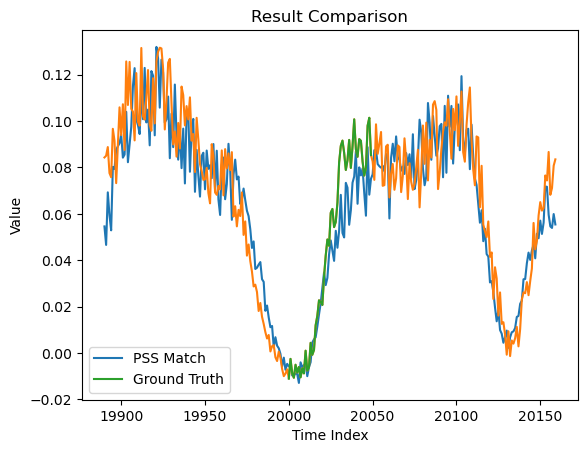

In [357]:
plt.plot(index_PT,pss_matches[0], label="PSS Match")
plt.plot(gt0)
plt.plot(index_GT, ground_truth, label="Ground Truth")

plt.title('Result Comparison')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.show()

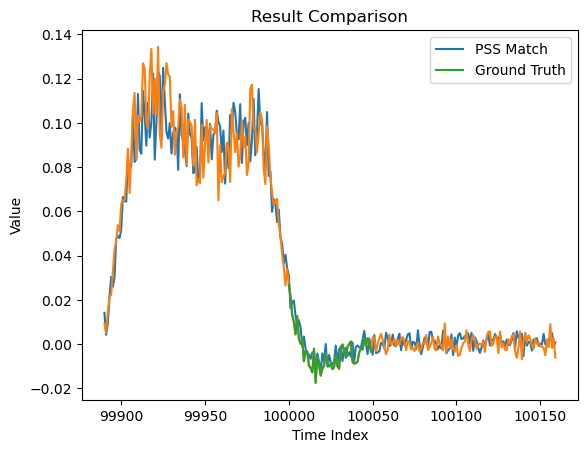

In [383]:
plt.plot(index_PT,pss_matches[0], label="PSS Match")
plt.plot(gt0)
plt.plot(index_GT, ground_truth, label="Ground Truth")

plt.title('Result Comparison')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.show()